In [9]:
## Simulation for unwrapping error correction with bridging
## useful skimage functions: http://scikit-image.org/docs/stable/auto_examples/index.html
# link: http://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html
# http://scikit-image.org/docs/stable/api/skimage.segmentation.html#relabel-sequential
# http://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops
# http://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.profile_line
# http://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label
# 

import os
import sys
import time
import pickle
import numpy as np
import random
from matplotlib import pyplot as plt
from skimage import measure, segmentation as seg, morphology as morph
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim, fractal
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.objects.conncomp import connectComponent
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet

work_dir = os.path.expandvars('$PNOTE/sim_bridging')

# configure
shape = (300, 300) # size in (length, width) in pixel number
length, width = shape
ref_x, ref_y = int(0.9*width), int(0.2*length)
work_dir = os.path.join(work_dir, '300unzen')

#shape = (100, 100) # size in (length, width) in pixel number
#length, width = shape
#ref_x, ref_y = int(0.95*width), int(0.95*length)
#work_dir = os.path.join(work_dir, '100square')

os.chdir(work_dir)
print('Go to directory: '+work_dir)

# ref attributes
ref_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
ref_file = os.path.join(ref_dir, 'timeseries.h5')
atr = readfile.read_attribute(ref_file)
L = int(atr['ALOOKS']) * int(atr['RLOOKS'])
range2phase = -4. * np.pi / float(atr['WAVELENGTH'])
resolution = ut.range_ground_resolution(atr)

# update atr
atr['LENGTH'] = length
atr['WIDTH'] = width
atr['REF_Y'] = ref_y
atr['REF_X'] = ref_x

# output file
sim_int_file = os.path.join(work_dir, 'sim.int')
sim_cor_file = os.path.join(work_dir, 'sim.cor')
sim_unw_file = os.path.join(work_dir, 'sim.unw')
snf_unw_file = os.path.join(work_dir, 'snf.unw')
bdg_unw_file = os.path.join(work_dir, 'bdg_snf.unw')
cc_file = snf_unw_file+'.conncomp'

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_bridging/300unzen


In [10]:
# utilities functions
from skimage import draw, transform as trans

def simulate_conn_comp(shape, ref_file=None, n=5):
    if ref_file:
        mask = readfile.read(ref_file, box=(0,200,3000,2700))[0]
        mask = trans.resize(mask, shape, mode='reflect', anti_aliasing=False)
        mask = mask == 1.0
    else:
        mask = np.ones(shape)
        # generate decorrelated boundaries
        rr, cc = draw.bezier_curve(int(0.0 *length),int(0.65*width), int(0.50*length),int(0.50*width), int(0.80*length),int(1.00*width),weight=2,shape=shape); mask[rr,cc] = 0
        rr, cc = draw.bezier_curve(int(0.40*length),int(0.0 *width), int(0.20*length),int(0.30*width), int(0.35*length),int(0.57*width),weight=1,shape=shape); mask[rr,cc] = 0
        rr, cc = draw.bezier_curve(int(0.50*length),int(0.62*width), int(0.50*length),int(0.80*width), int(0.25*length),int(1.00*width),weight=1,shape=shape); mask[rr,cc] = 0
        rr, cc = draw.circle(r=int(0.46*length), c=int(0.6*width), radius=int(0.20*length), shape=shape); mask[rr,cc] = 0
        # expand the boundaries
        for i in range(n):
            mask = morph.erosion(mask)
    return mask

def write_ifgram(sim_unw, sim_cor):
    print('write to file', sim_int_file)
    sim_int = np.zeros(sim_unw.shape, np.complex64)
    sim_int = np.cos(ut.wrap(sim_unw)) + 1j * np.sin(ut.wrap(sim_unw))
    sim_int.tofile(sim_int_file)
    print('write to file', sim_cor_file)
    sim_cor.tofile(sim_cor_file)
    print('write to file', sim_unw_file)
    writefile.write(sim_unw, sim_unw_file, atr)
    return

def plot_ifgram_simulation(defo, trop, ramp, decor, sim_unw):
    labels = ['defo', 'tropo', 'ramp', 'decor', 'total']
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[10, 2], sharey=True)
    for i, data, label in zip(range(len(labels)), [defo, trop, ramp, decor, sim_unw], labels):
        ax = axs[i]
        im = ax.imshow(ut.wrap(data), cmap='jet', vmin=-np.pi, vmax=np.pi)
        ax.plot(ref_x, ref_y,'ks',ms=3)
        ax.set_title(label)
    fig.subplots_adjust(left=0.02, right=0.95, bottom=0.02, top=0.98)
    # colorbar
    cax = fig.add_axes([0.97, 0.3, 0.01, 0.4])
    cbar = plt.colorbar(im, cax=cax, ticks=[-np.pi, 0, np.pi])
    cbar.ax.set_yticklabels([r'-$\pi$', '0', r'$\pi$'])
    cbar.set_label('phase [rad]', fontsize=font_size)
    plt.savefig('sim_int.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
    plt.show()
    return

def plot_snpahu_result(snf_unw_file, sim_unw_file, cc_file=None):
    if not cc_file:
        cc_file = snf_unw_file+'.conncomp'
    cc = readfile.read(cc_file)[0]

    snf_unw = readfile.read(snf_unw_file)[0]
    snf_unw -= snf_unw[ref_y, ref_x]
    snf_unw[cc==0] = np.nan

    sim_unw = readfile.read(sim_unw_file)[0]
    sim_unw[cc==0] = np.nan

    vmin, vmax = np.nanmin(sim_unw), np.nanmax(sim_unw)
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[10, 2.5], sharey=True)
    im1 = axs[0].imshow(sim_unw, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title('truth')
    im1 = axs[1].imshow(snf_unw, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title('snaphu')
    
    unw_diff = sim_unw - snf_unw
    vlim = np.nanmax(np.abs(unw_diff))
    im2 = axs[2].imshow(unw_diff, cmap='jet', vmin=-1.*vlim, vmax=vlim); axs[2].set_title('difference')
    for ax in axs[:-1]:
        ax.plot(ref_x, ref_y,'ks',ms=3)

    axs[3].imshow(cc, cmap='jet'); axs[3].set_title('conn comps')

    # colorbar
    cax1 = fig.add_axes([0.23, -0.02, 0.15, 0.03])
    cax2 = fig.add_axes([0.54, -0.02, 0.15, 0.03])
    cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
    cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
    for cbar in [cbar1, cbar2]:
        cbar.set_label('rad', fontsize=font_size)
    plt.show()
    return

print('source utils functions.')

source utils functions.


In [11]:
# simulate interferometric phase
re_generate = False
if not os.path.isfile(sim_int_file) or re_generate:
    print('simulating interferometric phase and coherence ...')
    # 1. simulate deformation from Mogi source
    source_geom = (0.4*width*resolution, 0.4*length*resolution, 2e3, 1e6)  #Mogi (east, north, depth, vol change)
    #source_geom = (0.4*width*resolution, 0.4*length*resolution, 2e3, 1.5e6)  #Mogi (east, north, depth, vol change)
    defo = sim.mogi_deformation(shape, source_geom, resolution=resolution, display=False) * range2phase
    defo -= defo[ref_y, ref_x]
    
    # 2. simulate tropospheric turbulence
    trop = fractal.fractal_surface_atmos(shape=shape, resolution=resolution, p0=1e-3) * range2phase
    trop -= trop[ref_y, ref_x]

    # 3. ramp
    if 'unzen' in work_dir:
        ramp_scale = -3.
    else:
        ramp_scale = -8.
    xx, yy = np.meshgrid(np.arange(0, width), np.arange(0, length))
    ramp = (xx * -0.04 + yy * 0.02) * ramp_scale
    ramp -= ramp[ref_y, ref_x]

    # 4. decorrelation noise
    if 'unzen' in work_dir:
        Unzen_waterMaskFile = '/Users/yunjunz/insarlab/Kyushu/AlosDT74F2960/PYSAR/waterMask.h5'
        mask = simulate_conn_comp(shape, ref_file=Unzen_waterMaskFile)
    else:
        mask = simulate_conn_comp(shape)

    # simulate decorrelation noise
    sim_cor = np.zeros(shape, np.float32)
    decor = np.zeros(shape)
    for flag, cor in zip([0, 1], [0.001, 0.6]):
        mask0 = mask == flag
        decor0 = sim.sample_decorrelation_phase(L, cor, size=length*width).reshape(length, width)
        decor[mask0] = decor0[mask0]
        sim_cor[mask0] = cor
    decor -= decor[ref_y, ref_x]

    # 5. sum up
    sim_unw = defo + trop + ramp + decor
    sim_unw = np.array(sim_unw, np.float32)

    # save / plot
    write_ifgram(sim_unw, sim_cor)
    plot_ifgram_simulation(defo, trop, ramp, decor, sim_unw)

    # run SNAPHU
    #!unwrap_ifgram.py -i $sim_int_file -u $snf_unw_file -c $sim_cor_file
    cmd = 'unwrap_isce_ifgram.py -i {} -u {} -c {}'.format(sim_int_file, snf_unw_file, sim_cor_file)
    os.system(cmd)
    plot_snpahu_result(snf_unw_file, sim_unw_file)

    # run bridging
    # 1. prep conn_comp
    conncomp = readfile.read(cc_file)[0]
    cc = connectComponent(conncomp=conncomp, metadata=atr)
    cc.label(min_area=50, erosion_size=1)
    cc.find_mst_bridge()
    # 2. run unwrap_conn_comp
    snf_unw = readfile.read(snf_unw_file)[0]
    bdg_unw = cc.unwrap_conn_comp(snf_unw, atr, ramp_type='linear', print_msg=False)
    writefile.write(bdg_unw, bdg_unw_file, atr)
else:
    print('files exist, no need to re-generate.')

files exist, no need to re-generate.


saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_bridging/300unzen/sim_bridging.png


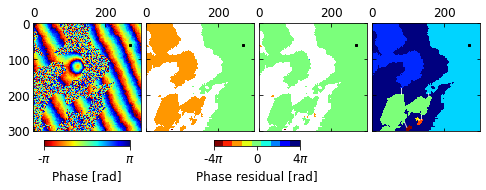

In [20]:
## plot bridging vs SNAPHU

# read data
conncomp = readfile.read(cc_file)[0]
cc = connectComponent(conncomp=conncomp, metadata=atr)
cc.label(min_area=50, erosion_size=1)
cc.find_mst_bridge()

sim_unw = readfile.read(sim_unw_file)[0]; sim_unw -= sim_unw[ref_y, ref_x];# sim_unw[cc.conncomp==0] = np.nan
snf_unw = readfile.read(snf_unw_file)[0]; snf_unw -= snf_unw[ref_y, ref_x];# snf_unw[cc.conncomp==0] = np.nan
bdg_unw = readfile.read(bdg_unw_file)[0]; bdg_unw -= bdg_unw[ref_y, ref_x];# bdg_unw[cc.conncomp==0] = np.nan
sim_int = ut.wrap(sim_unw)
snf_err = sim_unw - snf_unw
bdg_err = sim_unw - bdg_unw
snf_err[cc.conncomp==0] = np.nan
bdg_err[cc.conncomp==0] = np.nan
Nmax = np.round(np.nanmax(np.abs(snf_err)) / np.pi).astype(int)
vlim = Nmax * np.pi

# plot
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[8, 2.5], sharex=True, sharey=True)
im1 = axs[0].imshow(sim_int, cmap='jet_r', vmin=-np.pi,   vmax=np.pi)
# residual phase
cmap = pp.ColormapExt(cmap_name='jet_r', cmap_lut=2*Nmax+1).colormap
im2 = axs[1].imshow(snf_err, cmap=cmap, vmin=-1.*vlim, vmax=vlim)
im3 = axs[2].imshow(bdg_err, cmap=cmap, vmin=-1.*vlim, vmax=vlim)
im4 = axs[3].imshow(cc.labelImg, cmap='jet')
for bridge in cc.bridges:
    axs[3].plot([bridge['x0'], bridge['x1']],
                [bridge['y0'], bridge['y1']], 'w-', lw=1, alpha=0.8)

# axis format
for ax in axs:
    ax.plot(ref_x, ref_y, 'ks', ms=2)
    ax.xaxis.tick_top()
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.subplots_adjust(wspace=0.05)
#axs[1,1].set_xlabel('Range [pix.]', fontsize=font_size)
#pp.set_shared_ylabel(axs.flatten(), 'Azimuth [pix.]', font_size=font_size, labelpad=-0.075)

## colorbar
cax1 = fig.add_axes([0.143, 0.12, 0.15, 0.03])
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=[-np.pi, np.pi])
cbar1.ax.set_xticklabels([r'-$\pi$', r'$\pi$'])
cbar1.ax.tick_params(labelsize=font_size)
cbar1.set_label('Phase [rad]', fontsize=font_size)

cax2 = fig.add_axes([0.438, 0.12, 0.15, 0.03])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal', ticks=[-1.*vlim, 0, vlim])
cbar2.ax.set_xticklabels([r'-{}$\pi$'.format(Nmax), '0', r'{}$\pi$'.format(Nmax)])
cbar2.ax.tick_params(labelsize=font_size)
cbar2.set_label('Phase residual [rad]', fontsize=font_size)

# save
out_file = os.path.join(os.getcwd(), 'sim_bridging.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

In [11]:
np.round(np.nanmax(np.abs(snf_err)) / np.pi).astype(int)

4

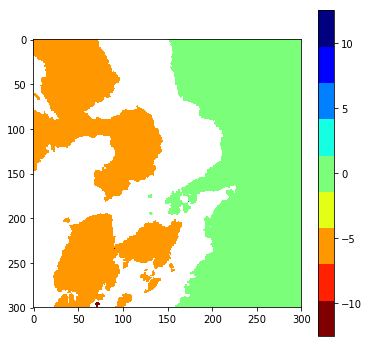

In [25]:
plt.figure(figsize=[6,6])
cmap = pp.ColormapExt(cmap_name='jet_r', cmap_lut=2*Nmax+1).colormap
im = plt.imshow(snf_err, cmap=cmap, vmin=-1.*vlim, vmax=vlim)
plt.colorbar(im)
plt.show()

saved to file sim_bridging.png


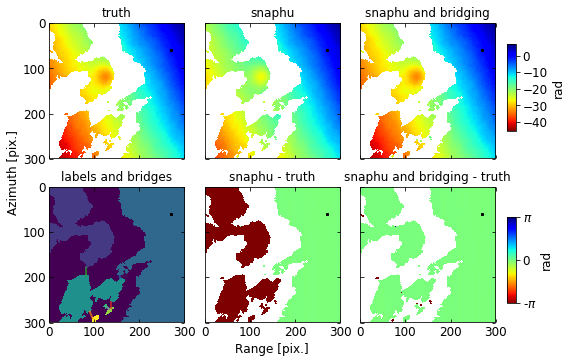

In [86]:
## plot bridging vs SNAPHU

# read data
conncomp = readfile.read(cc_file)[0]
cc = connectComponent(conncomp=conncomp, metadata=atr)
cc.label(min_area=50, erosion_size=1)
cc.find_mst_bridge()

sim_unw = readfile.read(sim_unw_file)[0]; sim_unw -= sim_unw[ref_y, ref_x]; sim_unw[cc.conncomp==0] = np.nan
snf_unw = readfile.read(snf_unw_file)[0]; snf_unw -= snf_unw[ref_y, ref_x]; snf_unw[cc.conncomp==0] = np.nan
bdg_unw = readfile.read(bdg_unw_file)[0]; bdg_unw -= bdg_unw[ref_y, ref_x]; bdg_unw[cc.conncomp==0] = np.nan

# plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[8, 6], sharex=True, sharey=True)
vmin, vmax = np.nanmin(sim_unw), np.nanmax(sim_unw)
im1 = axs[0,0].imshow(sim_unw, cmap='jet_r', vmin=vmin, vmax=vmax); axs[0,0].set_title('truth')
im1 = axs[0,1].imshow(snf_unw, cmap='jet_r', vmin=vmin, vmax=vmax); axs[0,1].set_title('snaphu')
im1 = axs[0,2].imshow(bdg_unw, cmap='jet_r', vmin=vmin, vmax=vmax); axs[0,2].set_title('snaphu and bridging')

axs[1,0].imshow(cc.labelImg); axs[1,0].set_title('labels and bridges')
for bridge in cc.bridges:
    axs[1,0].plot([bridge['x0'], bridge['x1']], [bridge['y0'], bridge['y1']], '-', lw=2, alpha=0.7)

vlim = 1.*np.pi
im2 = axs[1,1].imshow(sim_unw-snf_unw, cmap='jet_r', vmin=-vlim, vmax=vlim); axs[1,1].set_title('snaphu - truth')
im2 = axs[1,2].imshow(sim_unw-bdg_unw, cmap='jet_r', vmin=-vlim, vmax=vlim); axs[1,2].set_title('snaphu and bridging - truth')
fig.subplots_adjust(hspace=0.01, wspace=0.15)

# axis format
for ax in axs.flatten():
    ax.plot(ref_x, ref_y, 'ks', ms=2)
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
axs[1,1].set_xlabel('Range [pix.]'  , fontsize=font_size)
pp.set_shared_ylabel(axs.flatten(), 'Azimuth [pix.]', font_size=font_size, labelpad=-0.075)

# colorbar
cax1 = fig.add_axes([0.92, 0.6, 0.015, 0.2])
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.ax.tick_params(labelsize=font_size)
cbar1.set_label('rad', fontsize=font_size)

cax2 = fig.add_axes([0.92, 0.2, 0.015, 0.2])
cbar2 = plt.colorbar(im2, cax=cax2, ticks=[-np.pi, 0, np.pi])
cbar2.ax.set_yticklabels([r'-$\pi$', '0', r'$\pi$'])
cbar2.ax.tick_params(labelsize=font_size)
cbar2.set_label('rad', fontsize=font_size)

# save
out_file = 'sim_bridging.png'
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

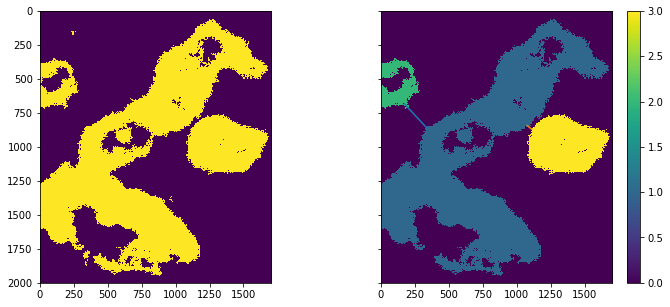

time used: 1.01 secs.


In [32]:
start_time = time.time()
# *.unw.conncomp --> label_mask
unw_cc = readfile.read(snf_unw_file+'.conncomp')[0]
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
ifgram_file = os.path.join(proj_dir, 'INPUTS/ifgramStack.h5')
unw_cc, atr = readfile.read(ifgram_file, datasetName='connectComponent-20150611_20150903')
#unw_cc = readfile.read(os.path.join(proj_dir, 'mask.h5'))[0]

cc = connectComponent(conncomp=unw_cc, metadata=atr)
cc.label()
cc.find_mst_bridge()

#plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12,5], sharey=True)
axs[0].imshow(unw_cc)
im = axs[1].imshow(cc.labelImg)
for bridge in cc.bridges:
    plt.plot([bridge['x0'], bridge['x1']], [bridge['y0'], bridge['y1']], '-')
plt.colorbar(im)
plt.show()
print('time used: {:.2f} secs.'.format(time.time()-start_time))

In [4]:
import os
import itertools
from scipy.sparse import csgraph as csg
from scipy.spatial import cKDTree
from skimage import measure, segmentation as seg, morphology as morph
from pysar.utils import readfile, utils as ut

class connectComponent:
    def __init__(self, conncomp, metadata):
        """Parameters: conncomp : str or 2D np.ndarray in np.bool_ format
                       metadata : dict, attributes
        """
        if isinstance(conncomp, str):
            self.conncomp = readfile.read(conncomp)[0]
        elif type(conncomp).__module__ == np.__name__:
            self.conncomp = conncomp
        else:
            raise ValueError('No connected component data input!')        
        self.metadata = metadata
        self.refY = int(self.metadata['REF_Y'])
        self.refX = int(self.metadata['REF_X'])
        self.length, self.width = self.conncomp.shape

    def label(self, min_area=1e4, erosion_size=5):
        label_image = measure.label(self.conncomp, connectivity=1)
        # take regions with large enough areas
        min_area = min(min_area, label_image.size * 3e-3)
        flag_slabel = np.bincount(label_image.flatten()) < min_area
        flag_slabel[0] = False
        label_small = np.where(flag_slabel)[0]
        for i in label_small:
            label_image[label_image == i] = 0
        # re-label
        self.labelImg, self.numLabel = measure.label(label_image, connectivity=1, return_num=True)
        # reference label, where reference pixel is located
        self.labelRef = self.labelImg[self.refY, self.refX]
        # find label boundaries to facilitate bridge finding
        self.find_boundary(erosion_size=erosion_size)
        return

    def find_boundary(self, erosion_size=5):
        self.labelErosion = morph.erosion(self.labelImg, morph.disk(erosion_size)).astype(np.uint8)
        self.labelBound = seg.find_boundaries(self.labelErosion, mode='thick').astype(np.uint8)
        self.labelBound *= self.labelErosion
        return

    def get_all_connections(self):
        regions = measure.regionprops(self.labelBound)
        if len(regions) < self.numLabel:
            msg = 'Some regions are too small --> lost during erosion.'
            msg += '\n1) decrease erosion_size value, or'
            msg += '\n2) increase min_area value.'
            raise ValueError(msg)

        trees = []
        for i in range(self.numLabel):
            trees.append(cKDTree(regions[i].coords))

        self.connDict = dict()
        self.distMat = np.zeros((self.numLabel, self.numLabel), dtype=np.float32)
        for i, j in itertools.combinations(range(self.numLabel), 2):
            # find shortest bridge
            dist, idx = trees[i].query(regions[j].coords)
            idx_min = np.argmin(dist)
            yxj = regions[j].coords[idx_min,:]
            yxi = regions[i].coords[idx[idx_min],:]
            dist_min = dist[idx_min]
            # save
            n0, n1 = str(i+1), str(j+1)
            conn = dict()
            conn[n0] = yxi
            conn[n1] = yxj
            conn['distance'] = dist_min
            self.connDict['{}{}'.format(n0, n1)] = conn
            self.distMat[i,j] = self.distMat[j,i] = dist_min
        return

    def find_mst_bridge(self):
        if not hasattr(self, 'distMat'):
            self.get_all_connections()

        # MST bridges with breadth_first_order
        distMatMst = csg.minimum_spanning_tree(self.distMat)
        succs, preds = csg.breadth_first_order(distMatMst, i_start=self.labelRef-1, directed=False)

        # save to self.bridges
        self.bridges = []
        for i in range(1, succs.size):
            n0 = preds[succs[i]] + 1
            n1 = succs[i] + 1
            # read conn
            nn = sorted([str(n0), str(n1)])
            conn = self.connDict['{}{}'.format(nn[0], nn[1])]
            y0, x0 = conn[str(n0)]
            y1, x1 = conn[str(n1)]
            # save bdg
            bridge = dict()
            bridge['x0'] = x0
            bridge['y0'] = y0
            bridge['x1'] = x1
            bridge['y1'] = y1
            bridge['label0'] = n0
            bridge['label1'] = n1
            self.bridges.append(bridge)
        self.num_bridge = len(self.bridges)
        return

    def unwrap_conn_comp(self, unw, atr, radius=50, ramp_type=None, print_msg=False):
        start_time = time.time()
        radius = int(min(radius, min(self.conncomp.shape)*0.05))

        ref_y, ref_x = int(atr['REF_Y']), int(atr['REF_X'])
        unw -= unw[ref_y, ref_x]
        unw = np.array(unw, dtype=np.float32)

        if ramp_type is not None:
            if print_msg:
                print('estimate a {} ramp'.format(ramp_type))
            ramp_mask = (self.labelImg == self.labelImg[ref_y, ref_x])
            unw, ramp = ut.deramp_data(unw, ramp_mask, ramp_type, metadata=atr)

        for bridge in self.bridges:
            # get mask of AOI
            x0, y0 = bridge['x0'], bridge['y0']
            x1, y1 = bridge['x1'], bridge['y1']
            x00 = max(0, x0 - radius); x01 = min(self.width,  x0 + radius)
            y00 = max(0, y0 - radius); y01 = min(self.length, y0 + radius)
            x10 = max(0, x1 - radius); x11 = min(self.width,  x1 + radius)
            y10 = max(0, y1 - radius); y11 = min(self.length, y1 + radius)
            aoi_mask0 = np.zeros(self.labelImg.shape, dtype=np.bool_)
            aoi_mask1 = np.zeros(self.labelImg.shape, dtype=np.bool_)
            aoi_mask0[y00:y01, x00:x01] = True
            aoi_mask1[y10:y11, x10:x11] = True

            label_mask0 = self.labelImg == bridge['label0']
            label_mask1 = self.labelImg == bridge['label1']

            # get phase difference
            value0 = np.nanmedian(unw[aoi_mask0 * label_mask0])
            value1 = np.nanmedian(unw[aoi_mask1 * label_mask1])
            diff_value = value1 - value0

            # estimate integer number of phase jump
            num_jump = (np.abs(diff_value) + np.pi) // (2.*np.pi)
            if diff_value > 0:
                num_jump *= -1

            if print_msg:
                print('phase diff {}-{}: {:04.1f} rad --> num of jump: {}'.format(bridge['label1'],
                                                                                  bridge['label0'],
                                                                                  diff_value,
                                                                                  num_jump))

            # add phase jump
            unw[label_mask1] += 2.* np.pi * num_jump
        
        # add ramp back
        if ramp_type is not None:
            unw += ramp
        if print_msg:
            print('time used: {:.2f} secs.'.format(time.time()-start_time))
        return unw

    def plot_bridge(self):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 3], sharey=True)
        im = axs[0].imshow(self.conncomp)
        im = axs[1].imshow(self.labelImg)
        for bridge in self.bridges:
            axs[1].plot([bridge['x0'], bridge['x1']], [bridge['y0'], bridge['y1']], '-', lw=2)
        axs[1].plot(self.refX, self.refY, 'ks')
        plt.colorbar(im)
        plt.show()
        return
print('connectComponent class')

connectComponent class
